# Naive Bayes

Naive Bayes is a common baseline technique for spam detection. Here, we explore how this method can be used to detect trolls solely from the text of a tweet. We first do a bit more exploration of our dataset based only on the content of the tweets. Then we try to classify trolls vs non-trolls of the common random and temporal splits that we created.

## Table of content
- <a href="#cleaning">Cleaning up the dataset</a>
- <a href="#cloud">Cloud exploration</a>
- <a href="#train">Training and testing the model</a>
- <a href="#Conclusion">Conclusion</a>

<div id="cleaning"></div>

## Cleaning up the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
troll_df = pd.read_csv("../data/troll_jun_to_nov_v2.csv", index_col="Unnamed: 0")
troll_df.head()

,Unnamed: 0.1,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,has_link
45,2161,1.504356e+09,GALLOWAYELIANA,"#CharlotteUprising protests at NFL game, cuts ...",United States,English,2016-10-05 13:48:00,10/5/2016 13:49,1000,1148,1799,RETWEET,left,0,1,LeftTroll,True
46,2162,1.504356e+09,GALLOWAYELIANA,Gotta stay high all my life to forget I'm miss...,United States,English,2016-10-05 13:48:00,10/5/2016 13:48,1000,1148,1798,RETWEET,left,0,1,LeftTroll,True
47,2163,1.504356e+09,GALLOWAYELIANA,How to send the perfect demo https://t.co/3dWa...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1803,RETWEET,left,0,1,LeftTroll,True
48,2164,1.504356e+09,GALLOWAYELIANA,Feeling superior hasn't caused an entire race ...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1801,RETWEET,left,0,1,LeftTroll,True
49,2165,1.504356e+09,GALLOWAYELIANA,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,United States,English,2016-10-05 14:51:00,10/5/2016 14:51,1000,1148,1802,RETWEET,left,0,1,LeftTroll,True


In [3]:
del troll_df["Unnamed: 0.1"]

The techniques that we'll use highly depends on the language that we are dealing with, so we'll only keep English. By doing so we won't get rid of too many samples as most of the tweets we have in our dataset are in English:

In [4]:
troll_df.language.value_counts()

English               166252
French                   321
Spanish                  207
Vietnamese               188
Italian                  174
Dutch                    100
German                    97
Portuguese                80
Arabic                    72
Norwegian                 63
Romanian                  57
Estonian                  51
Swedish                   44
Albanian                  41
Farsi (Persian)           37
Japanese                  31
Catalan                   30
Croatian                  30
Uzbek                     28
Polish                    22
Lithuanian                22
LANGUAGE UNDEFINED        19
Hindi                     17
Icelandic                 16
Turkish                   13
Hungarian                 12
Kurdish                   11
Russian                   10
Tagalog (Filipino)         9
Somali                     9
Finnish                    9
Danish                     8
Czech                      6
Indonesian                 6
Bulgarian     

In [5]:
troll_df = troll_df[troll_df.language == 'English']

We manually add a label to say that these tweets are troll tweets.

In [6]:
troll_df["is_troll"] = 1

In [7]:
non_troll_df = pd.read_json("../data/non_troll_data_simplified_v4.json")
non_troll_df.head()

,index,created_at,id,is_quote_status,lang,possibly_sensitive,retweet_count,retweeted,scopes,source,text,truncated,withheld_in_countries,followers,following,is_a_retweet,has_link
0,603148,2016-11-08 16:58:18,796034121906745344,False,en,0.0,50924,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @HillaryClinton: Don't stand still. Vote to...,False,None,387,359,True,True
1,603149,2016-11-08 22:34:35,796118750059700224,False,es,0.0,229,False,None,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @Javierito321: Yo si gana Trump / Yo si gan...,False,None,685,949,True,True
10,603158,2016-11-09 03:40:03,796195620541243392,True,en,0.0,0,False,None,"<a href=""http://twitter.com/download/iphone"" r...",THANK GOD https://t.co/XKSWHg133c,False,None,131,33,False,True
100,603248,2016-11-09 02:28:06,796177513613402112,False,en,0.0,12809,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @J4CKMULL: Hillary Clinton really did the #...,False,None,338,315,True,True
1000,604148,2016-11-08 13:46:47,795985921342640128,True,en,NaN,1,False,None,"<a href=""http://twitter.com/download/iphone"" r...",RT @OthewhomaniT: #ElectionDay\nRaise your han...,False,None,2245,1633,True,False


We manually put a label to say that these tweets are trolls.

In [8]:
non_troll_df["is_troll"] = 0

In [9]:
non_troll_df = non_troll_df.rename(columns={"text": "content"})

In [10]:
non_troll_df.lang.value_counts()

en     962426
und     39316
es      27108
fr       6544
pt       2868
it       2427
de       2198
in       1332
tr       1015
nl        971
ar        931
tl        914
ja        910
ht        571
ca        444
th        395
pl        386
sv        382
ru        254
da        246
et        244
ro        234
hi        201
el        179
ko        136
no        135
cy        134
cs         97
fi         91
fa         85
vi         79
eu         72
zh         65
ur         58
lt         56
hu         46
lv         34
sl         33
iw         32
is         31
uk         20
ne         12
ta         10
bn          5
sr          5
ml          4
mr          3
am          2
si          2
te          2
ka          1
bg          1
Name: lang, dtype: int64

English seems to be way less dominant in this dataset than in the troll one, let's verify that the few dominant languages are correct.

In [11]:
non_troll_df[non_troll_df.lang == 'en'].sample(10).content

728880       The spokes lady is pissed at this VP debate 😂😂😂
369045     RT @aristotle52: Americans Are Going to be Dis...
1045640    RT @TeamTrump: There’s no doubt Obama-Clinton’...
67768      RT @starfirst: “Trump tries to prove he isn’t ...
216197     Oh FFS do NOT let @DWStweets on stage! You wan...
772723     RT @iJesseWilliams: Trump is the king of empty...
698059     @radiodaneault Me either, but I totally believ...
808716     RT @DollyParton: I've been told a few times I ...
342528     RT @RyanLizza: Here's the video of an official...
606873     @CNN #RNCinCLE be honest the drop in coal jobs...
Name: content, dtype: object

`und` is used when the language was not automatically detected. These tweets generally only have hashtags or @ mentions. To make sure that we do not pick up non-english hashtags and @ mentions, we'll get rid of this category.

In [12]:
non_troll_df[non_troll_df.lang == 'und'].sample(10).content

720883          RT @aewsome: #debate https://t.co/sYt4ikBcy6
1022760    ⬇️ #racism #truth #CrookedHillary #democrats #...
202183     #TNDemsinPhilly #DemsInPhilly #DemConvention  ...
792199     RT @karmasenz: #ElectionDay #Election2016 #Ele...
134259     #millennials #CrookedHillary #DNCinPHL #libera...
973281               @HillaryClinton https://t.co/37RkudEOEn
240567     RT @JaymeWoj: #Debates #ItsInOurHands #Jill201...
988753     #debatenight #debate #HillaryClinton #Trump ht...
311400     RT @KumulusKloud: #DebateNight https://t.co/Qc...
775672                           lol https://t.co/MJv0TSu7nn
Name: content, dtype: object

In [13]:
non_troll_df[non_troll_df.lang == 'es'].sample(10).content

396144    Tony Suárez, el pastor evangélico latino que a...
102746    RT MichelPesquera: Jamás el voto latino para T...
892040    RT @usavsarg: USA HILLARY CLINTON vs ARGENTINI...
40620     RT @Ja51Javiera: perdón si alguien se ofende p...
629207    Por si alguien dudaba que el tema del discurso...
912603    RT @Eduardo_Soto18: No sé por qué hablan de lo...
297468    RT @operador_: Resumen del #Debates2016 https:...
795535    RT @PelayoFG: Llega un momento en que ya no te...
76483     RT @homozapp: Donald Trump denunciará a Carlos...
281935    RT @abc_es: Termina el debate entre Hillary Cl...
Name: content, dtype: object

In [14]:
non_troll_df[non_troll_df.lang == 'fr'].sample(10).content

672727    RT @BFMTV: La campagne d'Hillary Clinton mise ...
12034     RT @MarieCFiset: L’enthousiasme des partisans ...
32836     Tous les bons de ce monde en somme...#oùvalemo...
943347    RT @RTenfrancais: Julian Assange à RT : "j’épr...
687034    RT @lea_srg: "Hillary Clinton championne de bo...
810773    Score sérré entre Clinton et Trump\nCartograph...
22537        Voilà j'avais dit DEPUIS LE DÉBUT #ElectionDay
930789    RT @KimJongUnique: #CrookedHillary pourra suiv...
275466    In French "une petite fessée" https://t.co/7af...
789398         donald trump: mais feminista que eu? #debate
Name: content, dtype: object

Languages seem to be correct, we'll only keep English once again.

In [15]:
non_troll_df = non_troll_df[non_troll_df.lang == 'en']

Now let's make the classes even.

In [16]:
print("There are {} observations in the troll dataset.".format(troll_df.shape[0]))
print("There are {} observatins in the non-troll dataset.".format(non_troll_df.shape[0]))

There are 166252 observations in the troll dataset.
There are 962426 observatins in the non-troll dataset.


We will randomly downsample the non-troll dataset to have the same number of tweets in each category.

In [17]:
non_troll_df_undersampled = non_troll_df.sample(n=troll_df.shape[0], random_state=123)

In [18]:
print("There are {} observations in the troll dataset.".format(troll_df.shape[0]))
print("There are {} observatins in the non-troll undersampled dataset.".format(non_troll_df_undersampled.shape[0]))

There are 166252 observations in the troll dataset.
There are 166252 observatins in the non-troll undersampled dataset.


In [19]:
full_df = pd.concat((troll_df[["content", "is_troll"]],
                     non_troll_df_undersampled[["content", "is_troll"]]))

In [20]:
full_df.is_troll.value_counts()

1    166252
0    166252
Name: is_troll, dtype: int64

In [21]:
full_df.head()

,content,is_troll
45,"#CharlotteUprising protests at NFL game, cuts ...",1
46,Gotta stay high all my life to forget I'm miss...,1
47,How to send the perfect demo https://t.co/3dWa...,1
48,Feeling superior hasn't caused an entire race ...,1
49,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,1


Let's clean up the indexes of the full dataset.

In [22]:
full_df.reset_index(drop=True, inplace=True)

In [23]:
full_df.head()

,content,is_troll
0,"#CharlotteUprising protests at NFL game, cuts ...",1
1,Gotta stay high all my life to forget I'm miss...,1
2,How to send the perfect demo https://t.co/3dWa...,1
3,Feeling superior hasn't caused an entire race ...,1
4,Tomm Night at UWIï¿½ï¿½ï¿½ Lets do Thisï¿½ï¿½ ...,1


<div id="cloud"></div>

## Cloud exploration

In [24]:
def create_word_cloud(full_df, troll_label):
    words = ' '.join(full_df[full_df.is_troll == troll_label].content.values)
    wc = WordCloud(width = 512,height = 512).generate(words)
    plt.figure(figsize = (10, 8), facecolor = 'k')
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

Let's see which words are more popular within the troll dataset.

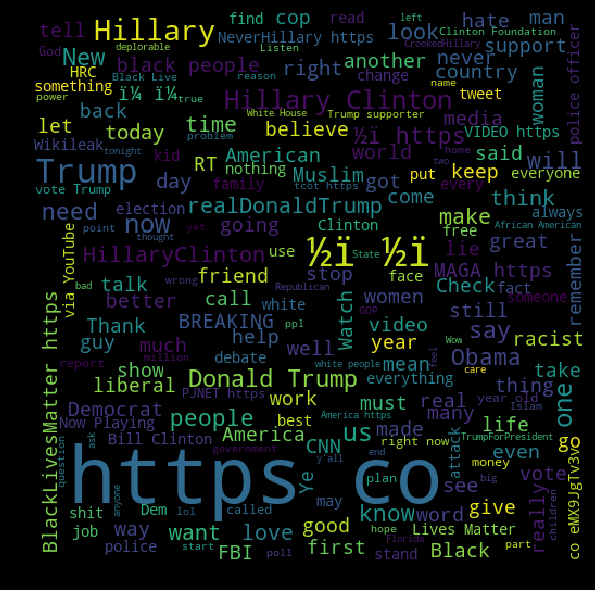

Wall time: 10.9 s


In [25]:
%%time
create_word_cloud(full_df, troll_label=1)

Now with the non-troll dataset.

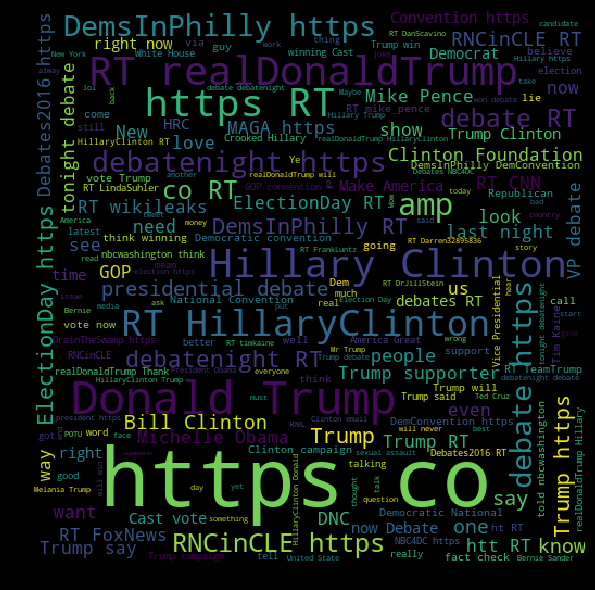

Wall time: 10.7 s


In [26]:
%%time
create_word_cloud(full_df, troll_label=0)

These word clouds reveal at least two things on the differences of the two datasets:
 - Racial-related tweets seem to be way more present in troll tweets than in non-troll tweets: "Black", "White", "African American", "BlackLivesMatter", "black people" are easily noticeable in the troll cloud whereas they seem completely absent of the non-troll cloud.
 - The non-troll tweets seem much more factual, generally mentioning big events (e.g. Debate Night, Election Day) or candidates (e.g. Donald Trump, Hillary Clinon). On the contrary, words like "police", "women", "Muslim", and "racist" that can easily be found in the troll word cloud may remind us of touchy controversies that happened during the presidential elections.

Let's see to what they actually refer to on some example troll tweets.

In [27]:
def show_tweets_about(dataframe, subject, max_num=10):
    for i, tweet in enumerate(dataframe.content[dataframe.content.apply(lambda x: subject in x)][:max_num], 1):
        print(i, tweet)

In [28]:
touchy_subjects = ["police", "women", "Muslim", "racist"]

In [29]:
for subject in touchy_subjects:
    print("##### Subject: {}".format(subject))
    show_tweets_about(troll_df, subject)
    print("\n")

##### Subject: police
1 LRT: The Chicago police ARE a criminal gang.
2 Newark police killed two black teenagers this past Saturday  https://t.co/hR4fj5VGOj https://t.co/7H2z6EZeoB
3 You'll hear police asking for "respect",men demanding "respect", because demanding submission and obedience reveals the means of domination
4 4-6 armed men have stormed a police training center in #Quetta, #Pakistan & 200 cadets hostages ï¿½ https://t.co/XAAYrvbSzX via @metesohtaoglu
5 Social justice warriors have vowed to call the police on people wearing âoffensiveâ Halloween costumes. Yes, really. https://t.co/odrRcouV7S
6 Twice now CNN has deceptively edited video to present a particular narrative of police shootings â>  https://t.co/1H6OQT98Yx
7 2 police officers shot in San Diego and all #BlackLivesMatter members keep silent Don't their lifes matter? https://t.co/2QjpLSPpQG
8 The police worried about "gang" violence when they are the only "gang" being violent
9 Suspect in Boston police shooting 

These indeed usually refer to touchy subjects.

<div id="train"></div>

## Training and testing the model

Let's use the common train and test splits that we have created to be used for our model-based predictions. This data was cleaned in the same way that we did above and can thus directly be used to do predictions.

In [30]:
in_file = '../data/merged_troll_data.json'
data_df = pd.read_json(in_file)

In [31]:
# Read the indices file
index_file = '../data/train_test_inds.json'
idx_df = pd.read_json(index_file)

In [32]:
def get_train_test(mode):
    """We combine valid and train into the same dataset."""
    train_df = data_df.iloc[idx_df[mode]["train"]]
    valid_df = data_df.iloc[idx_df[mode]["val"]]
    test_df = data_df.iloc[idx_df[mode]["test"]]
    return pd.concat((train_df, valid_df)), test_df

In [33]:
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [34]:
def naive_bayes_classification(mode, feature_extractor, alphas=None):
    
    if alphas is None:
        alphas = [i/10 for i in range(1, 11)]
    
    print("Loading {} split...".format(mode))
    train_df, test_df = get_train_test(mode)
    
    print("Applying and fitting transform...")
    x_train = feature_extractor.fit_transform(train_df["content"])
    y_train = train_df["troll"]
    
    x_test = feature_extractor.transform(test_df["content"])
    y_test = test_df["troll"]
    
    print("Performing cross-validation to find best alpha from {}".format(alphas))
    # We perform cross-validation to get the best regularization parameter
    alpha_scores = []
    for alpha in alphas:
        scores = cross_val_score(naive_bayes.MultinomialNB(alpha=alpha), x_train, y_train, cv=5)
        mean_score = np.mean(scores)
        print("Cross-validation accuracy for alpha={} is {}".format(alpha, mean_score))
        alpha_scores.append((alpha, mean_score))
    best_alpha, best_score = max(alpha_scores, key=lambda x: x[1])
    print("Best score {} was obtained with alpha={}".format(best_score, best_alpha))
    print("Retraining the model on the whole training set...")
    best_model = naive_bayes.MultinomialNB(alpha=best_alpha).fit(x_train, y_train)
    print("Train score of best model is {}".format(best_model.score(x_train, y_train)))
    print("Test score of best model is {}".format(best_model.score(x_test, y_test)))

### Naive Bayes using Bag-Of-Words

Let's see how Naive Bayes performs on our random split.

In [35]:
%%time
naive_bayes_classification(mode="random", feature_extractor=feature_extraction.text.CountVectorizer(stop_words='english'))

Loading random split...
Applying and fitting transform...
Performing cross-validation to find best alpha from [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Cross-validation accuracy for alpha=0.1 is 0.8806394585407122
Cross-validation accuracy for alpha=0.2 is 0.8806260915113493
Cross-validation accuracy for alpha=0.3 is 0.8805492337585061
Cross-validation accuracy for alpha=0.4 is 0.8800580136165905
Cross-validation accuracy for alpha=0.5 is 0.8797338727156644
Cross-validation accuracy for alpha=0.6 is 0.879182499406172
Cross-validation accuracy for alpha=0.7 is 0.8787714759688743
Cross-validation accuracy for alpha=0.8 is 0.8783470848322121
Cross-validation accuracy for alpha=0.9 is 0.8779494269726509
Cross-validation accuracy for alpha=1.0 is 0.8776319711218104
Best score 0.8806394585407122 was obtained with alpha=0.1
Retraining the model on the whole training set...
Train score of best model is 0.9596963104797612
Test score of best model is 0.8808456888514631
Wall time: 14.8 s

Let's see how Naive Bayes performs on our temporal split.

In [36]:
%%time
naive_bayes_classification(mode="temporal", feature_extractor=feature_extraction.text.CountVectorizer(stop_words='english'))

Loading temporal split...
Applying and fitting transform...
Performing cross-validation to find best alpha from [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Cross-validation accuracy for alpha=0.1 is 0.8779493997953454
Cross-validation accuracy for alpha=0.2 is 0.8782635127302421
Cross-validation accuracy for alpha=0.3 is 0.878206702255184
Cross-validation accuracy for alpha=0.4 is 0.8777555770598072
Cross-validation accuracy for alpha=0.5 is 0.877471535013705
Cross-validation accuracy for alpha=0.6 is 0.8769769708951556
Cross-validation accuracy for alpha=0.7 is 0.8762785657900913
Cross-validation accuracy for alpha=0.8 is 0.875733876302425
Cross-validation accuracy for alpha=0.9 is 0.8750855946681405
Cross-validation accuracy for alpha=1.0 is 0.8746144233116248
Best score 0.8782635127302421 was obtained with alpha=0.2
Retraining the model on the whole training set...
Train score of best model is 0.9530363939542795
Test score of best model is 0.84355357733602
Wall time: 15 s


### Naive Bayes using TF-IDF

We do the same comparison using TF-IDF:
For our random split, we obtain:

In [37]:
%%time
naive_bayes_classification(mode="random", feature_extractor=feature_extraction.text.TfidfVectorizer(stop_words='english'))

Loading random split...
Applying and fitting transform...
Performing cross-validation to find best alpha from [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Cross-validation accuracy for alpha=0.1 is 0.8541367975925074
Cross-validation accuracy for alpha=0.2 is 0.8545043804315989
Cross-validation accuracy for alpha=0.3 is 0.854420843937751
Cross-validation accuracy for alpha=0.4 is 0.8538293713826175
Cross-validation accuracy for alpha=0.5 is 0.8531710650206208
Cross-validation accuracy for alpha=0.6 is 0.8526330586846915
Cross-validation accuracy for alpha=0.7 is 0.85194133667549
Cross-validation accuracy for alpha=0.8 is 0.8514066720829071
Cross-validation accuracy for alpha=0.9 is 0.8507149497945514
Cross-validation accuracy for alpha=1.0 is 0.850170260697654
Best score 0.8545043804315989 was obtained with alpha=0.2
Retraining the model on the whole training set...
Train score of best model is 0.9504967368748183
Test score of best model is 0.8577787134221527
Wall time: 14.7 s


On our temporal split:

In [38]:
%%time
naive_bayes_classification(mode="temporal", feature_extractor=feature_extraction.text.TfidfVectorizer(stop_words='english'))

Loading temporal split...
Applying and fitting transform...
Performing cross-validation to find best alpha from [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Cross-validation accuracy for alpha=0.1 is 0.8492746631020361
Cross-validation accuracy for alpha=0.2 is 0.848860295018064
Cross-validation accuracy for alpha=0.3 is 0.8482621418237356
Cross-validation accuracy for alpha=0.4 is 0.8469321615679775
Cross-validation accuracy for alpha=0.5 is 0.845378292657063
Cross-validation accuracy for alpha=0.6 is 0.8436172414070826
Cross-validation accuracy for alpha=0.7 is 0.8421535971109095
Cross-validation accuracy for alpha=0.8 is 0.8405095052044238
Cross-validation accuracy for alpha=0.9 is 0.8388453616092886
Cross-validation accuracy for alpha=1.0 is 0.8372447100218118
Best score 0.8492746631020361 was obtained with alpha=0.1
Retraining the model on the whole training set...
Train score of best model is 0.9599937176903823
Test score of best model is 0.8026224775194731
Wall time: 14.5 

## Conclusion

Unfortunately, it seems that Naive Bayes significantly overfits on the training set despite the regularization parameter and the usage of cross-validation. This shows the need to use other types of models that would allow us the usage of more regularization techniques.